In [3]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.gridspec import GridSpec

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY
from mtj.types import MaterialProps

In [4]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.008,  # Damping factor (arbitrarily chosen in this demo)
    K_u=0,  # Crystal anisotropy constant, default: 0
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.zeros(3, dtype=np.float64),  # Not used when K_0 = 0
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=0,  # Temperature (K) - H_th diabled if 0
    Vol=1e-9 * 25e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([1, 0, 0]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=False,
    recompute_H_eff=False,
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))
    params: MaterialProps = {
        "K_u": K_u,
        "M_s": M_s,
        "u_k": u_k,
        "p": p,
        "a_para": a_par,
        "a_ortho": a_perp,
        "V": Volt,
        "H_app": H_app,
        "N": N,
    }

    for i, t in enumerate(time_series[:-1]):
        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(
            m[i],
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff,
            **params,
        )

    return m, time_series

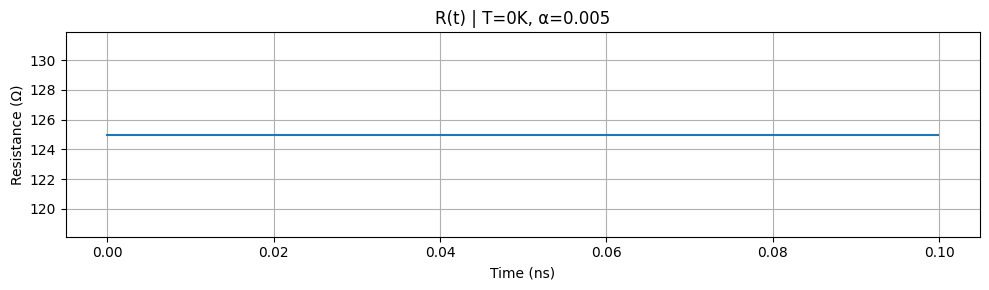

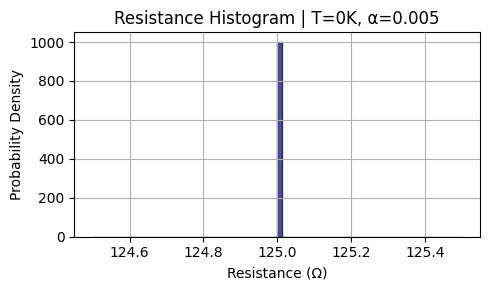

T=0K, α=0.005 → Mean R = 125.000 Ω, Std Dev = 0.00000 Ω


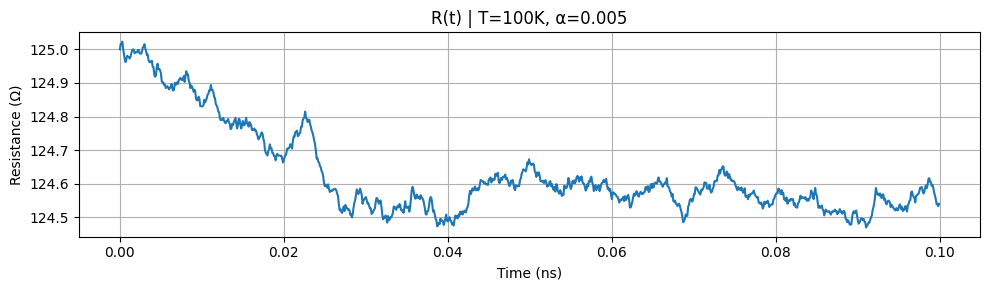

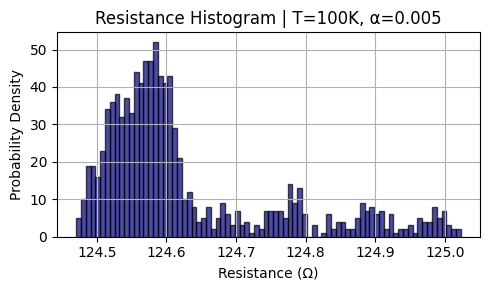

T=100K, α=0.005 → Mean R = 124.628 Ω, Std Dev = 0.13085 Ω


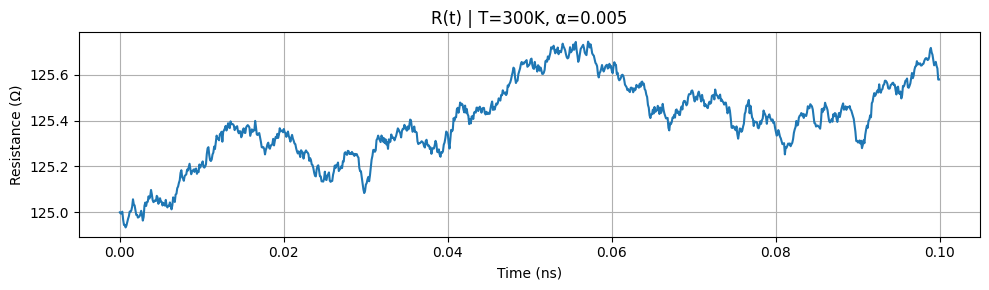

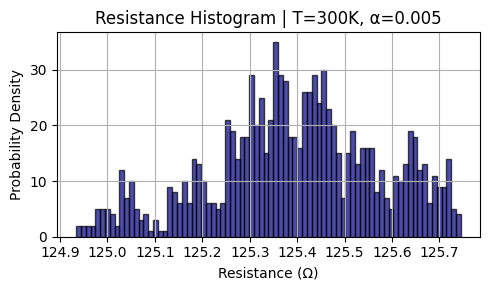

T=300K, α=0.005 → Mean R = 125.396 Ω, Std Dev = 0.17887 Ω


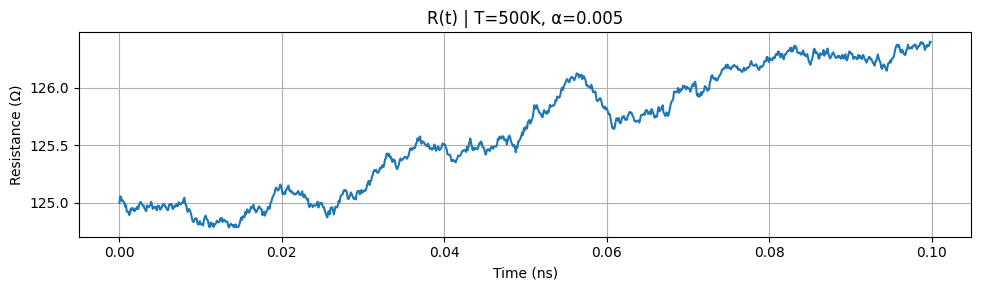

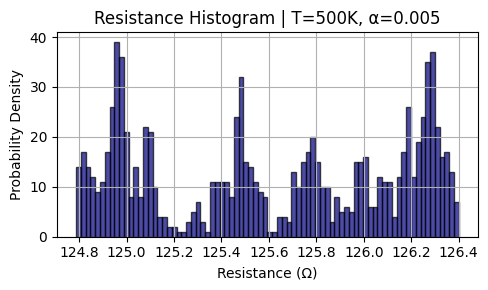

T=500K, α=0.005 → Mean R = 125.617 Ω, Std Dev = 0.52047 Ω


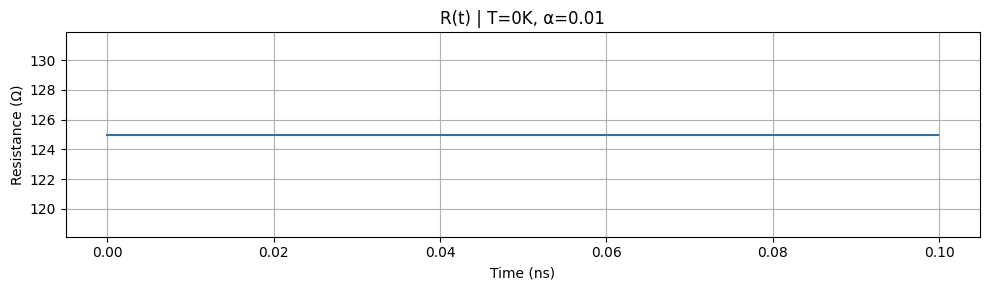

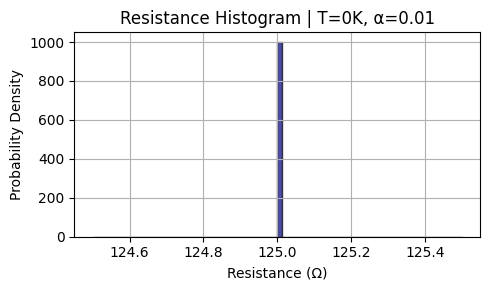

T=0K, α=0.01 → Mean R = 125.000 Ω, Std Dev = 0.00000 Ω


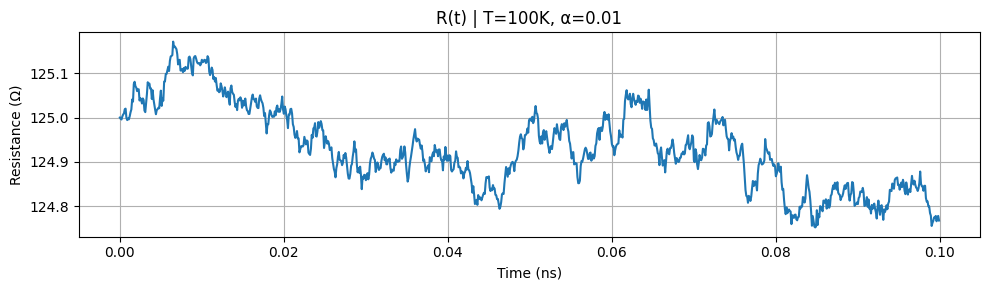

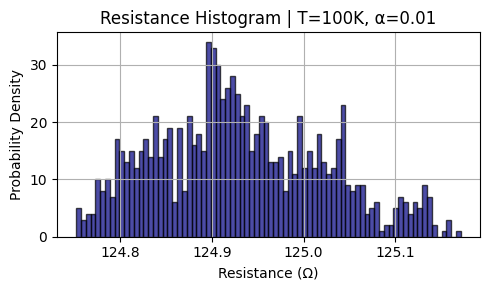

T=100K, α=0.01 → Mean R = 124.931 Ω, Std Dev = 0.09119 Ω


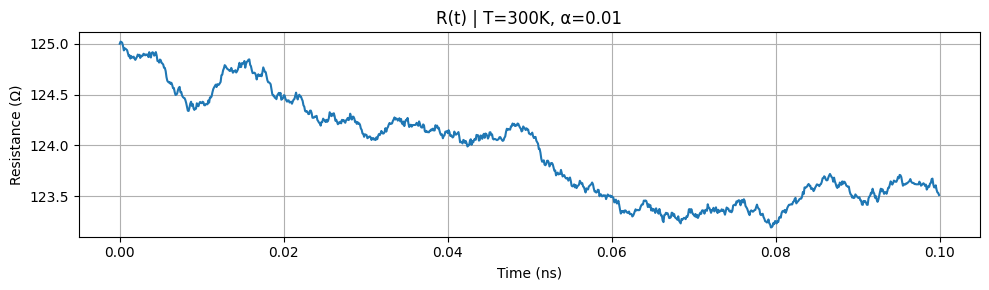

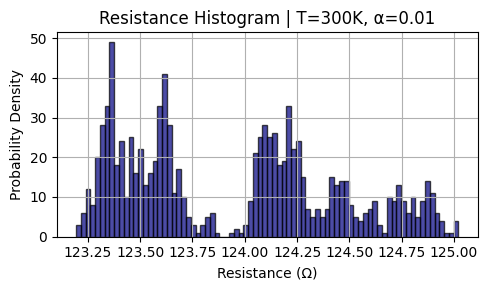

T=300K, α=0.01 → Mean R = 123.944 Ω, Std Dev = 0.49830 Ω


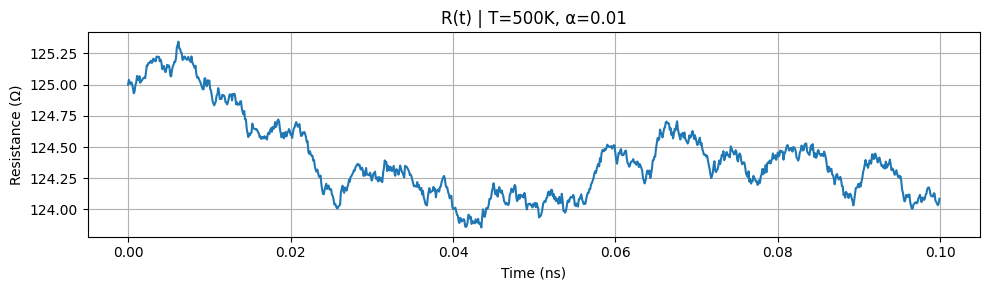

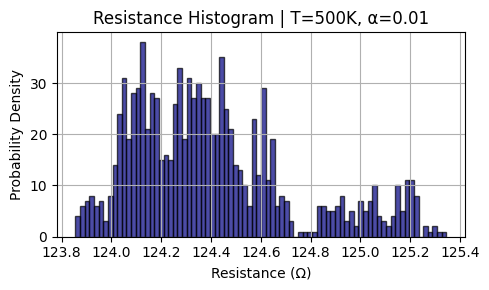

T=500K, α=0.01 → Mean R = 124.405 Ω, Std Dev = 0.32922 Ω


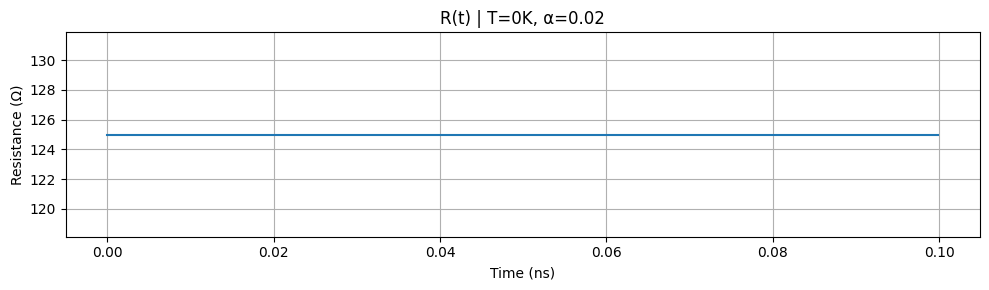

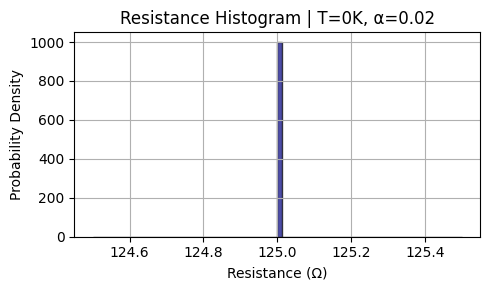

T=0K, α=0.02 → Mean R = 125.000 Ω, Std Dev = 0.00000 Ω


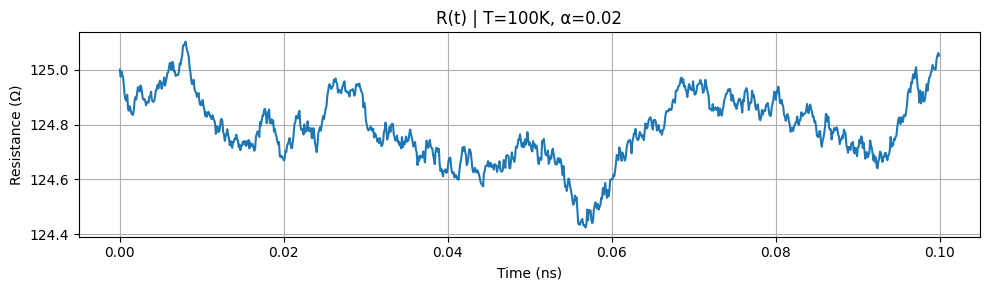

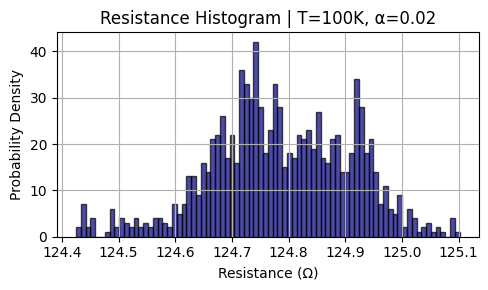

T=100K, α=0.02 → Mean R = 124.785 Ω, Std Dev = 0.12457 Ω


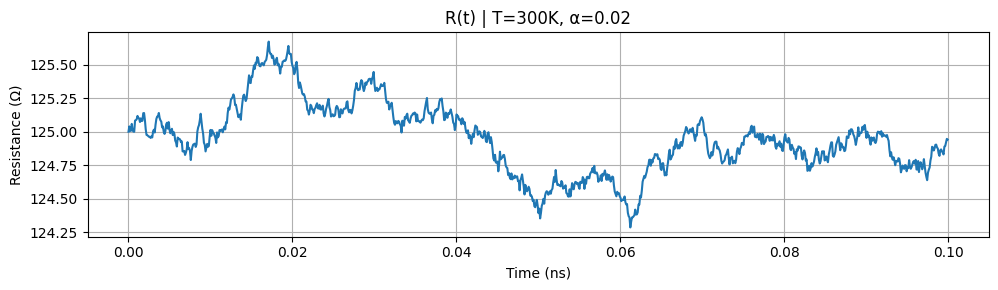

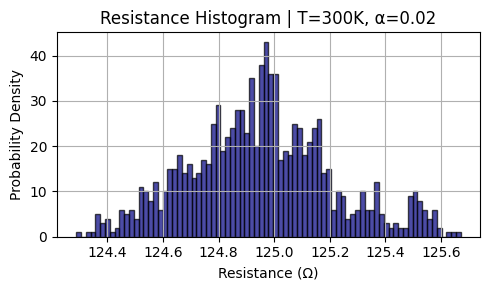

T=300K, α=0.02 → Mean R = 124.950 Ω, Std Dev = 0.25864 Ω


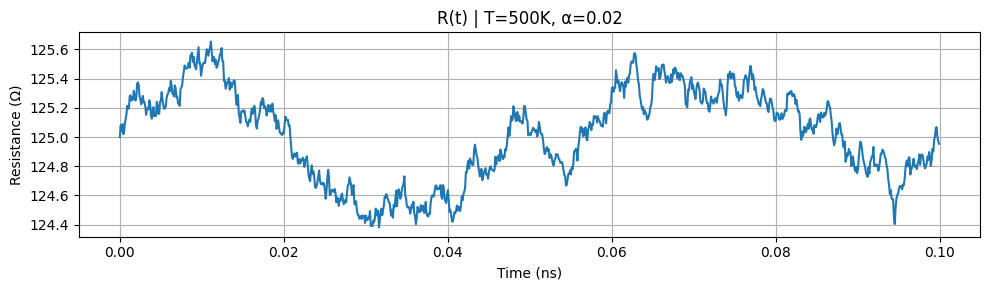

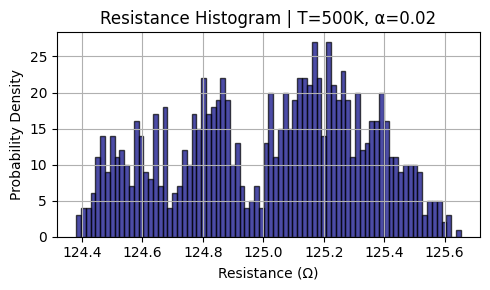

T=500K, α=0.02 → Mean R = 125.018 Ω, Std Dev = 0.31127 Ω


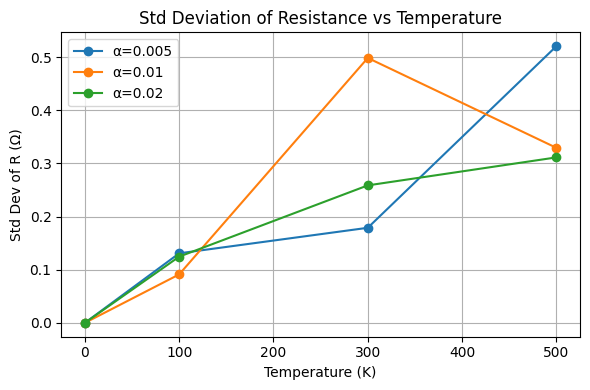

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Resistance model: TMR effect
def magnetization_to_resistance(m_z, R_P=100, delta_R=50):
    return R_P + (delta_R / 2) * (1 - m_z)

# Input ranges
alphas = [0.005, 0.01, 0.02]
temperatures = [0, 100, 300, 500]

# Store stats
std_devs_by_alpha = {alpha: [] for alpha in alphas}
means_by_alpha = {alpha: [] for alpha in alphas}

for alpha in alphas:
    for T in temperatures:
        m, ts = calculate_magnetization(
            m0=m0,
            H_app=H_app,
            Tn=Tn,
            dt=dt,
            alpha=alpha,
            M_s=1 / VACUUM_PERMEABILITY,
            Vol=Vol,
            T=T,
        )
        m_z = m[:, 2]
        R_series = magnetization_to_resistance(m_z)

        # --- Plot 1: Resistance vs Time ---
        plt.figure(figsize=(10, 3))
        plt.plot(ts * 1e9, R_series)
        plt.title(f"R(t) | T={T}K, α={alpha}")
        plt.xlabel("Time (ns)")
        plt.ylabel("Resistance (Ω)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Plot 2: Histogram of Resistance ---
        plt.figure(figsize=(5, 3))
        plt.hist(R_series, bins=80, alpha=0.7, color='navy', edgecolor='black')
        plt.title(f"Resistance Histogram | T={T}K, α={alpha}")
        plt.xlabel("Resistance (Ω)")
        plt.ylabel("Probability Density")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Store Statistics ---
        R_mean = np.mean(R_series)
        R_std = np.std(R_series)
        means_by_alpha[alpha].append(R_mean)
        std_devs_by_alpha[alpha].append(R_std)
        print(f"T={T}K, α={alpha} → Mean R = {R_mean:.3f} Ω, Std Dev = {R_std:.5f} Ω")

# --- Plot: Std Deviation vs Temperature for Each α ---
plt.figure(figsize=(6, 4))
for alpha in alphas:
    plt.plot(temperatures, std_devs_by_alpha[alpha], marker='o', label=f"α={alpha}")
plt.title("Std Deviation of Resistance vs Temperature")
plt.xlabel("Temperature (K)")
plt.ylabel("Std Dev of R (Ω)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()